In [1]:
import numpy as np
import pandas as pd
import re
import string
from pandas import DataFrame
from sqlalchemy import create_engine
from matplotlib import pyplot as plt
import matplotlib as mpl

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegressionCV
from sklearn import cross_validation
from sqlalchemy import create_engine
# import tensorflow as tf
%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
def get_information(query, host_db="cal-patent-lab.chhaitskv8dz.us-west-2.rds.amazonaws.com", 
                    username="***REMOVED***", password="***REMOVED***", db="***REMOVED***"):
    # Connecting to the fung db
    engine_fung = create_engine("mysql://{}:{}@{}/{}".format(
        username, password, host_db, db))
    connection_fung = engine_fung.connect()
    patent_info = pd.read_sql(
        query, engine_fung)
    connection_fung.close()
    return patent_info

# Predicting invalidation

First, we pull down all of the patents that have ever been brought before the PTAB

In [6]:
# Connecting to the db
host_db = "cal-patent-lab.chhaitskv8dz.us-west-2.rds.amazonaws.com"
username = "***REMOVED***"
password = "***REMOVED***"
db = "***REMOVED***"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()
q = "SELECT case_id, patent_id, invalidated, denied, filing_date, decision_date, patent_owner, petitioner_name FROM ptab_cases WHERE invalidated is not null and denied is not null"
ptab_patents = pd.read_sql(q, engine)
connection.close()

In [48]:
# Next, we want to grab the claims text associated with each patent and insert it into the dataframe

host_db = "***REMOVED***.berkeley.edu"
username = "uspto"
password = "ferrisbueller"
db = "uspto"

engine = create_engine("mysql://{}:{}@{}/{}".format(
    username, password, host_db, db))
connection = engine.connect()

patent_id = int(ptab_patents.patent_id[:1])

In [26]:
# Inserting concatenated claim text into ptab_patents

found = list()
for idx, patent_id in enumerate(ptab_patents.patent_id):
    q = "SELECT text from uspto.claim where patent_id = '{}'".format(patent_id)
    claims = pd.read_sql(q, engine)
    claims_concat = claims.text.str.cat()
    ptab_patents.loc[ptab_patents.patent_id == '{}'.format(patent_id), 'claim_text'] = claims_concat
    found.append(not claims.empty)
    if idx % 100 == 0:
        print("Processing patent {}".format(idx))

Processing patent 0
Processing patent 100
Processing patent 200
Processing patent 300
Processing patent 400
Processing patent 500
Processing patent 600
Processing patent 700
Processing patent 800
Processing patent 900
Processing patent 1000
Processing patent 1100
Processing patent 1200
Processing patent 1300
Processing patent 1400
Processing patent 1500
Processing patent 1600
Processing patent 1700
Processing patent 1800
Processing patent 1900
Processing patent 2000
Processing patent 2100
Processing patent 2200
Processing patent 2300
Processing patent 2400
Processing patent 2500
Processing patent 2600
Processing patent 2700
Processing patent 2800
Processing patent 2900
Processing patent 3000
Processing patent 3100
Processing patent 3200
Processing patent 3300
Processing patent 3400
Processing patent 3500
Processing patent 3600


In [3]:
# ptab_patents.to_pickle('ptab_patents_dany.pkl')

Loading pickled data, deduplicating patents, and running model

In [3]:
ptab_patents = pd.read_pickle('ptab_patents.pkl')
df = ptab_patents.dropna(axis=0, how='any')
df[df.invalidated == 1].shape

(1402, 7)

In [4]:
ptab_patents[ptab_patents.invalidated == 0]
mask = (ptab_patents[ptab_patents.invalidated == 0].claim_text.str.len() > 1)

In [5]:
df = ptab_patents.dropna(axis=0, how='any')
mask = (ptab_patents.claim_text.str.len() > 1)
df = df.loc[mask]

In [6]:
# De-duplicating patents
df = ptab_patents.dropna(axis=0, how='any')
mask = (ptab_patents.claim_text.str.len() > 1)
df = df.loc[mask]
dups = df.duplicated(subset='claim_text', keep='first')
df = df.loc[~dups]

X = df.claim_text.as_matrix()
y = df.invalidated.as_matrix()

In [6]:
# merigng the claims and the metadata
all_cases = get_information("SELECT * FROM ptab_cases")
all_info = get_information('SELECT * FROM patent_info')
ptab_cases = all_cases[all_cases.denied.notnull()]
ptab_stats = ptab_cases.merge(all_info,suffixes = ["_ptab", "_patent"], on="patent_id")
ptab_stats['petitioner_name'] = ptab_stats.petitioner_name.str.translate(None, string.punctuation).str.lower()
ptab_stats['art_unit2']= pd.Series(np.trunc(ptab_stats.art_unit.values.astype(np.float)/10.).astype(np.int)*10)
final = df.merge(ptab_stats, suffixes = ["_algo", "_all"], on="patent_id")

ImportError: No module named 'MySQLdb'

In [224]:
# De-duplicating patents
df = final.dropna(axis=0, how='any')
mask = (final.claim_text.str.len() > 1)
df = df.loc[mask]
dups = df.duplicated(subset='claim_text', keep='first')
df = df.loc[~dups]
X = df.claim_text.as_matrix()
df.art_unit2 = df.art_unit2.apply(str)
meta_X_all = pd.get_dummies(df[['petitioner_name', 'art_unit', 'examiner_name']]).as_matrix()
meta_X_all2 = pd.get_dummies(df[['petitioner_name', 'art_unit2', 'examiner_name']]).as_matrix()
meta_X_pet_art = pd.get_dummies(df[['petitioner_name', 'art_unit']]).as_matrix()
meta_X_pet_art2 = pd.get_dummies(df[['petitioner_name', 'art_unit2']]).as_matrix()
meta_X_art2 = pd.get_dummies(df[['art_unit2']]).as_matrix()
meta_X_art = pd.get_dummies(df[['art_unit']]).as_matrix()
y = df.invalidated_all.as_matrix()

In [15]:
X

array([ "A system that monitors and facilitates a review of data collected from a vehicle that is used to determine a level of safety or cost of insurance comprising:The system that monitors and facilitates a review of data collected from a vehicle of where the wireless transmitter is configured to transfer the selected vehicle data retained within the memory through a pulse position protocol without varying the power level or phase of a transmitting signal.The system that monitors and facilitates a review of data collected from a vehicle of where the wireless transmitter is compliant with a wireless transaction facilitator that throttles the transmission rates across the wireless network based on an available bandwidth of the wireless network.The system that monitors and facilitates a review of data collected from a vehicle of further comprising a dynamic memory allocation processor that allocates a portion of the memory to retain a copy of a legacy version of firmware that comprises 

In [21]:
def stem(X):
    stemmer2 = SnowballStemmer('english')
    stemmer = PorterStemmer()
    stemmed_X = []

    for elem in X:
        words = elem.split()
        new_claim = [stemmer.stem(word.decode('utf8')) for word in words]
        stemmed_X.append(' '.join(new_claim))
    return np.array(stemmed_X)

new_X = stem(X) 

In [7]:
X

array([ "A system that monitors and facilitates a review of data collected from a vehicle that is used to determine a level of safety or cost of insurance comprising:The system that monitors and facilitates a review of data collected from a vehicle of where the wireless transmitter is configured to transfer the selected vehicle data retained within the memory through a pulse position protocol without varying the power level or phase of a transmitting signal.The system that monitors and facilitates a review of data collected from a vehicle of where the wireless transmitter is compliant with a wireless transaction facilitator that throttles the transmission rates across the wireless network based on an available bandwidth of the wireless network.The system that monitors and facilitates a review of data collected from a vehicle of further comprising a dynamic memory allocation processor that allocates a portion of the memory to retain a copy of a legacy version of firmware that comprises 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def train_model(X, meta, y, C):
    # data = np.hstack((np.asmatrix(X).T, meta))
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X, y, test_size=0.05, random_state=20)
    
    tfidf = TfidfVectorizer()
    tfidf.fit(X)
    X_train = tfidf.transform(X_train)
    X_test = tfidf.transform(X_test)
    print(X_train.shape)
    if meta != None:
        meta_train, meta_test, y_meta_train, y_meta_test = cross_validation.train_test_split(
            meta, y, test_size=0.2, random_state=20)  
        meta_X_train = np.hstack((X_train.toarray(), meta_train[:,:]))
        meta_X_test = np.hstack((X_test.toarray(), meta_test[:,:]))
        print(meta_X_train.shape)
    else:
        meta_X_train = X_train
        meta_X_test = X_test
    svc_class = LinearSVC(C=C, random_state=15)
    model = svc_class.fit(meta_X_train, y_train)
    # forest = RandomForestClassifier(random_state=15)
    # model = forest.fit(meta_X_train, y_train)
    # logistic_class = LogisticRegressionCV(Cs=np.arange(0.1, 5, 0.1), penalty='l2', dual=False, random_state=15, cv=5)

    logistic_class = LogisticRegression(C=C, penalty='l2', dual=True, random_state=15)
    model = logistic_class.fit(meta_X_train, y_train)

    precision = precision_score(y_test, model.predict(meta_X_test))
    recall = recall_score(y_test, model.predict(meta_X_test))

    print("Training accuracy is {0}".format(model.score(meta_X_train, y_train)))
    print("Testing accuracy is {0}".format(model.score(meta_X_test, y_test)))
    print("Precision is {0}".format(precision))
    print("Recall is {0}".format(recall))
    # score.append(model.score(meta_X_test, y_test))
    # vals = df.invalidated_all.value_counts()
    # print("Outcome of guessing is {}".format(float(vals[0])/float(sum(vals))))
    # print("N is {0}".format(sum(vals)))
    
    return model, X_test, y_test, tfidf

In [11]:
model3, X_test, y_test, tf = train_model(X, None, y, 2.3)

(1534, 14339)
Training accuracy is 0.914602346806
Testing accuracy is 0.740740740741
Precision is 0.8
Recall is 0.166666666667


In [12]:
import pickle
f = open('invalidation_model.pkl', 'wb')
pickle.dump(model3, open('invalidation_model.pkl', 'wb'))
pickle.dump(tf, open('invalidation_tfidf.pkl', 'wb'))
f.close()

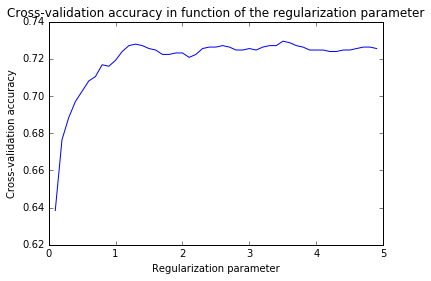

In [382]:
plt.plot(model.Cs_, np.mean(model.scores_[1.], axis=0))
plt.xlabel('Regularization parameter')
plt.ylabel('Cross-validation accuracy')
plt.title('Cross-validation accuracy in function of the regularization parameter')

In [371]:
model.Cs_[np.argmax(np.mean(model.scores_[1.], axis=0))]

3.5000000000000004

Recall is high when we keep our false negatives low and precision is high when we keep our false positives low. Basically, this classifier is overindexing on precision relative to recall. A next step here would be to look at tradeoffs between precision and recall between different probabalistic classifiers. We probably also want to play with regularization.

In [388]:
# only works when with random forest
np.argsort(model3.feature_importances_)[-10:]
for feature in np.argsort(model3.feature_importances_)[-10:]:
    for word in tf.vocabulary_:
        if tf.vocabulary_[word] == feature:
            print word

or
correspond
of
from
plural
user
to
comprising
provid
the


In [403]:
np.sort(model3.feature_importances_)

array([ 0.        ,  0.        ,  0.        , ...,  0.00830895,
        0.00844366,  0.00854598])

# Neural Network

In [24]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    new_X, y, test_size=0.2, random_state=20)

tfidf = TfidfVectorizer()
tfidf.fit(new_X)
X_train = tfidf.transform(X_train)
X_test = tfidf.transform(X_test)

In [66]:
sess = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 12677])
y_ = tf.placeholder(tf.float32, shape=[None, 2])
                   
W_h = tf.Variable(tf.zeros([X_train.shape[1], 2000]))
b_h = tf.Variable(tf.zeros([2000]))

h = tf.nn.softmax(tf.matmul(x, W_h) + b_h)

W_o = tf.Variable(tf.zeros([2000, 2]))
b_o = tf.Variable(tf.zeros([2]))

y = tf.nn.softmax(tf.matmul(h, W_o) + b_o)
y_ = tf.placeholder(tf.float32, [None, 2])

# cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [72]:
tf.global_variables_initializer().run()

for _ in range(300):
    print(_)
    batch_xs, batch_ys = X_train.toarray(), np.vstack((np.abs(y_train - 1), y_train)).T
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [75]:
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: X_test.toarray(), y_: np.vstack((np.abs(y_test - 1), y_test)).T}))

0.606811


In [71]:
print(x.get_shape())

(?, 12677)
